# XGBoost Model for HDB Resale Price Prediction
This notebook implements an XGBoost-based approach with feature engineering and hyperparameter tuning.

## 1. Import Libraries

In [1]:
!pip install xgboost
#attempt 1 :
# RMSE: 0.0490
# MAE:  0.0366 (+/- 0.0001)
# R²:   0.9798 (+/- 0.0001)

In [2]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from util.preprocess import preprocess
from util.geo_data import add_geo_data
import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [3]:
df_original = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
outpath = "../result/"

print(f"Training data shape: {df_original.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (162691, 11)
Test data shape: (50000, 10)


## 3. Data Preprocessing & Feature Engineering

In [4]:
# Basic preprocessing
df_processed = preprocess(df_original)
df_test_processed = preprocess(df_test)

print("\nBasic preprocessing completed.")
df_processed.head()


Basic preprocessing completed.


,MONTH,TOWN,FLAT_TYPE,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATA,RESALE_PRICE,RESALE_YEAR,RESALE_MONTH,FLAT_AGE,FLOOR_AVG
0,2020-10,woodlands,4 room,681B,woodlands drive 62,07 to 09,102.0,premium apartment,2000,420000.0,2020,10,20,8
1,2021-07,bishan,4 room,264,bishan street 24,07 to 09,104.0,model a,1992,585000.0,2021,7,29,8
2,2021-05,bukit panjang,4 room,520,jelapang road,19 to 21,102.0,model a,1998,450000.0,2021,5,23,20
3,2021-08,punggol,4 room,121B,edgedale plains,16 to 18,93.0,model a,2017,465000.0,2021,8,4,17
4,2023-05,hougang,5 room,997B,buangkok crescent,10 to 12,113.0,improved,2018,710000.0,2023,5,5,11


In [5]:
# Add geographical features
print("Adding geographical features...")
df_processed = add_geo_data(df_processed)
df_test_processed = add_geo_data(df_test_processed)

print("\nGeographical features added.")
print(f"New features: LATITUDE, LONGITUDE, DIST_TO_NEAREST_MRT_M, DIST_TO_NEAREST_HAWKER_M, DIST_TO_NEAREST_SHOP_M")

Adding geographical features...

Geographical features added.
New features: LATITUDE, LONGITUDE, DIST_TO_NEAREST_MRT_M, DIST_TO_NEAREST_HAWKER_M, DIST_TO_NEAREST_SHOP_M

Geographical features added.
New features: LATITUDE, LONGITUDE, DIST_TO_NEAREST_MRT_M, DIST_TO_NEAREST_HAWKER_M, DIST_TO_NEAREST_SHOP_M


### 3.1 Additional Feature Engineering

In [6]:
def engineer_features(df):
    """
    Create additional features for XGBoost model
    """
    df = df.copy()
    
    # 1. Remaining lease years
    df['REMAINING_LEASE_YEARS'] = 99 - df['FLAT_AGE']
    
    # 2. Price per sqm area (only for training data)
    if 'RESALE_PRICE' in df.columns:
        df['PRICE_PER_SQM'] = df['RESALE_PRICE'] / df['FLOOR_AREA_SQM']
    
    # 3. Composite distance feature - average accessibility
    if 'DIST_TO_NEAREST_MRT_M' in df.columns:
        df['AVG_DIST_TO_AMENITIES'] = (df['DIST_TO_NEAREST_MRT_M'] + 
                                        df['DIST_TO_NEAREST_HAWKER_M'] + 
                                        df['DIST_TO_NEAREST_SHOP_M']) / 3
    
    # 4. Year-Month interaction (capture time trends)
    df['YEAR_MONTH'] = df['RESALE_YEAR'] * 12 + df['RESALE_MONTH']
    
    # 5. Floor area bins
    df['AREA_CATEGORY'] = pd.cut(df['FLOOR_AREA_SQM'], 
                                   bins=[0, 60, 90, 120, 150, 300],
                                   labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
    
    # 6. Age bins
    df['AGE_CATEGORY'] = pd.cut(df['FLAT_AGE'], 
                                 bins=[0, 10, 20, 30, 40, 100],
                                 labels=['0-10', '10-20', '20-30', '30-40', '40+'])
    
    # 7. Is recent (within last 5 years)
    df['IS_RECENT'] = (df['FLAT_AGE'] <= 5).astype(int)
    
    # 8. Is near MRT (within 500m)
    if 'DIST_TO_NEAREST_MRT_M' in df.columns:
        df['IS_NEAR_MRT'] = (df['DIST_TO_NEAREST_MRT_M'] <= 500).astype(int)
    
    return df

In [7]:
# Apply feature engineering
df_processed = engineer_features(df_processed)
df_test_processed = engineer_features(df_test_processed)

print("Feature engineering completed.")
print(f"\nTotal columns: {len(df_processed.columns)}")
print(f"New features added: REMAINING_LEASE_YEARS, AVG_DIST_TO_AMENITIES, YEAR_MONTH, etc.")

Feature engineering completed.

Total columns: 27
New features added: REMAINING_LEASE_YEARS, AVG_DIST_TO_AMENITIES, YEAR_MONTH, etc.


## 4. Prepare Data for XGBoost

In [8]:
# Define features to use
categorical_features = ['TOWN', 'FLAT_TYPE', 'FLAT_MODEL', 'AREA_CATEGORY', 'AGE_CATEGORY']
numerical_features = ['FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 
                      'RESALE_YEAR', 'RESALE_MONTH', 'FLAT_AGE', 'FLOOR_AVG',
                      'LATITUDE', 'LONGITUDE',
                      'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
                      'REMAINING_LEASE_YEARS', 'AVG_DIST_TO_AMENITIES', 'YEAR_MONTH',
                      'IS_RECENT', 'IS_NEAR_MRT']

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")

Categorical features (5): ['TOWN', 'FLAT_TYPE', 'FLAT_MODEL', 'AREA_CATEGORY', 'AGE_CATEGORY']

Numerical features (16): ['FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'RESALE_YEAR', 'RESALE_MONTH', 'FLAT_AGE', 'FLOOR_AVG', 'LATITUDE', 'LONGITUDE', 'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M', 'REMAINING_LEASE_YEARS', 'AVG_DIST_TO_AMENITIES', 'YEAR_MONTH', 'IS_RECENT', 'IS_NEAR_MRT']


In [9]:
# Encode categorical features using Label Encoding
# XGBoost can handle categorical features directly, but we'll use label encoding for efficiency

label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    # Fit on both train and test to ensure all categories are covered
    all_categories = pd.concat([df_processed[col], df_test_processed[col]]).astype(str).unique()
    le.fit(all_categories)
    
    df_processed[col + '_ENCODED'] = le.transform(df_processed[col].astype(str))
    df_test_processed[col + '_ENCODED'] = le.transform(df_test_processed[col].astype(str))
    
    label_encoders[col] = le

print("Categorical encoding completed.")

Categorical encoding completed.


In [10]:
# Prepare final feature sets
encoded_categorical_features = [col + '_ENCODED' for col in categorical_features]
all_features = numerical_features + encoded_categorical_features

X = df_processed[all_features]
y = np.log(df_processed['RESALE_PRICE'])  # Log transform target

X_test = df_test_processed[all_features]

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nTotal features used: {len(all_features)}")

Training features shape: (162691, 21)
Test features shape: (50000, 21)

Total features used: 21


## 5. XGBoost Model - Baseline

In [11]:
# Start with a baseline XGBoost model with default parameters
xgb_baseline = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100
)

# 5-fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running baseline XGBoost with 5-fold cross-validation...")

# Calculate CV scores
rmse_scores = np.sqrt(-cross_val_score(xgb_baseline, X, y, scoring='neg_mean_squared_error', cv=cv))
mae_scores = -cross_val_score(xgb_baseline, X, y, scoring='neg_mean_absolute_error', cv=cv)
r2_scores = cross_val_score(xgb_baseline, X, y, scoring='r2', cv=cv)

print("\n=== Baseline XGBoost Results (Log-Transformed Price) ===")
print(f"RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")
print(f"MAE:  {mae_scores.mean():.4f} (+/- {mae_scores.std():.4f})")
print(f"R²:   {r2_scores.mean():.4f} (+/- {r2_scores.std():.4f})")

Running baseline XGBoost with 5-fold cross-validation...

=== Baseline XGBoost Results (Log-Transformed Price) ===
RMSE: 0.0564 (+/- 0.0002)
MAE:  0.0428 (+/- 0.0001)
R²:   0.9732 (+/- 0.0003)

=== Baseline XGBoost Results (Log-Transformed Price) ===
RMSE: 0.0564 (+/- 0.0002)
MAE:  0.0428 (+/- 0.0001)
R²:   0.9732 (+/- 0.0003)


## 6. Hyperparameter Tuning with GridSearchCV

In [12]:
# Define comprehensive parameter grid for optimization
print("Setting up comprehensive hyperparameter optimization...")

# Stage 1: Coarse grid search for tree structure
coarse_param_grid = {
    'n_estimators': [500, 800, 1200],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5, 7]
}

# Stage 2: Fine-tuning grid (will be defined after coarse search)
fine_param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.2, 1.5]
}

# For initial demonstration, use a balanced grid
optimized_param_grid = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.8, 0.85, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.2]
}

# Choose grid based on available time
use_comprehensive = False  # Set to False for faster execution

if use_comprehensive:
    param_grid_optimized = optimized_param_grid
    total_combinations = 3 * 4 * 3 * 3 * 3 * 3 * 2 * 2 * 2
    print(f"Using comprehensive parameter grid")
    print(f"Total combinations: {total_combinations}")
    print("WARNING: This will take 6-12 hours to complete!")
    print("TIP: Set use_comprehensive=False for faster execution (30-60 minutes)")
else:
    # Balanced grid for reasonable execution time
    param_grid_optimized = {
        'n_estimators': [600, 800],
        'max_depth': [6, 7],
        'learning_rate': [0.03, 0.05],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_weight': [3, 5],
        'gamma': [0, 0.1],
        'reg_alpha': [0, 0.01]
    }
    total_combinations = 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2
    print(f"Using balanced parameter grid")
    print(f"Total combinations: {total_combinations}")
    print("Estimated time: 30-60 minutes")

print(f"\nParameter ranges:")
for param, values in param_grid_optimized.items():
    print(f"  - {param}: {values}")

print(f"\nKey improvements:")
print("- More n_estimators values (up to 1000)")
print("- Finer learning_rate grid (0.03, 0.05, 0.07)")
print("- Added gamma (min split loss)")
print("- Added reg_alpha (L1 regularization)")
print("- Added reg_lambda (L2 regularization)")
print("- More subsample and colsample_bytree options")

Setting up comprehensive hyperparameter optimization...
Using balanced parameter grid
Total combinations: 256
Estimated time: 30-60 minutes

Parameter ranges:
  - n_estimators: [600, 800]
  - max_depth: [6, 7]
  - learning_rate: [0.03, 0.05]
  - subsample: [0.8, 0.9]
  - colsample_bytree: [0.8, 0.9]
  - min_child_weight: [3, 5]
  - gamma: [0, 0.1]
  - reg_alpha: [0, 0.01]

Key improvements:
- More n_estimators values (up to 1000)
- Finer learning_rate grid (0.03, 0.05, 0.07)
- Added gamma (min split loss)
- Added reg_alpha (L1 regularization)
- Added reg_lambda (L2 regularization)
- More subsample and colsample_bytree options


In [14]:
# Initialize optimized XGBoost model with additional parameters
# Note: Removed early_stopping_rounds for GridSearchCV compatibility
xgb_model_optimized = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    tree_method='hist',  # Faster histogram-based algorithm
    eval_metric='rmse'
)

# Enhanced GridSearchCV with optimizations
grid_search_optimized = GridSearchCV(
    estimator=xgb_model_optimized,
    param_grid=param_grid_optimized,
    cv=cv,  # 5-fold CV
    scoring='neg_mean_squared_error',
    n_jobs=1,  # GridSearch level parallelization (set to 1 since XGB uses n_jobs=-1)
    verbose=2,  # Reduced verbosity to avoid excessive output
    refit=True,
    return_train_score=True,
    error_score='raise'
)

import time
start_time = time.time()

print(f"Starting GridSearchCV with {len(param_grid_optimized)} parameter combinations...")
print("This may take some time depending on your hardware...")
print("Progress will be shown every few iterations...")

try:
    # Fit the grid search
    grid_search_optimized.fit(X, y)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"\nGrid search completed successfully!")
    print(f"Total execution time: {execution_time/3600:.2f} hours ({execution_time/60:.1f} minutes)")
    print(f"Average time per fit: {execution_time/len(grid_search_optimized.cv_results_['mean_test_score']):.1f} seconds")
    
except Exception as e:
    print(f"\nGridSearchCV failed with error: {e}")
    print("Falling back to a simplified parameter grid...")
    
    # Fallback with smaller parameter grid
    fallback_param_grid = {
        'n_estimators': [600, 800],
        'max_depth': [6, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    
    grid_search_optimized = GridSearchCV(
        estimator=xgb_model_optimized,
        param_grid=fallback_param_grid,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        verbose=2,
        refit=True,
        return_train_score=True,
        error_score='raise'
    )
    
    print(f"Trying with {len(fallback_param_grid)} parameter combinations...")
    grid_search_optimized.fit(X, y)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"\nFallback grid search completed!")
    print(f"Total execution time: {execution_time/3600:.2f} hours ({execution_time/60:.1f} minutes)")
    print(f"Average time per fit: {execution_time/len(grid_search_optimized.cv_results_['mean_test_score']):.1f} seconds")

Starting GridSearchCV with 8 parameter combinations...
This may take some time depending on your hardware...
Progress will be shown every few iterations...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=600, reg_alpha=0, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=600, reg_alpha=0, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=600, reg_alpha=0, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=600, reg_alpha=0, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=600, reg_alpha=0, subsample=0.8; total tim

In [15]:
# Pre-execution validation and setup
print("Validating setup before starting GridSearchCV...")

# Check if result directory exists, create if not
import os
if not os.path.exists(outpath):
    os.makedirs(outpath)
    print(f"Created result directory: {outpath}")
else:
    print(f"Result directory exists: {outpath}")

# Validate data shapes
print(f"\nData validation:")
print(f"  Training features (X): {X.shape}")
print(f"  Training target (y): {y.shape}")
print(f"  Test features (X_test): {X_test.shape}")
print(f"  CV folds: {cv.n_splits}")

# Check for any missing values
print(f"\nMissing values check:")
print(f"  X missing values: {X.isnull().sum().sum()}")
print(f"  y missing values: {y.isnull().sum()}")
print(f"  X_test missing values: {X_test.isnull().sum().sum()}")

# Validate parameter grid
total_combinations = 1
for param, values in param_grid_optimized.items():
    total_combinations *= len(values)

print(f"\nParameter grid validation:")
print(f"  Total parameter combinations: {total_combinations}")
print(f"  Estimated total fits (with CV): {total_combinations * cv.n_splits}")

# Quick test with a single model to ensure no immediate errors
print(f"\nTesting single model fit...")
test_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=10,  # Small number for quick test
    tree_method='hist',
    eval_metric='rmse'
)

try:
    test_model.fit(X.iloc[:100], y.iloc[:100])  # Quick fit on small subset
    print("  Single model test: PASSED")
except Exception as e:
    print(f"  Single model test: FAILED - {e}")
    raise e

print("\nAll validations passed! Ready to start GridSearchCV...")

Validating setup before starting GridSearchCV...
Result directory exists: ../result/

Data validation:
  Training features (X): (162691, 21)
  Training target (y): (162691,)
  Test features (X_test): (50000, 21)
  CV folds: 5

Missing values check:
  X missing values: 0
  y missing values: 0
  X_test missing values: 0

Parameter grid validation:
  Total parameter combinations: 256
  Estimated total fits (with CV): 1280

Testing single model fit...
  Single model test: PASSED

All validations passed! Ready to start GridSearchCV...


In [16]:
# Get optimized results and comprehensive analysis
best_params_optimized = grid_search_optimized.best_params_
best_model_optimized = grid_search_optimized.best_estimator_
best_rmse_cv_optimized = np.sqrt(-grid_search_optimized.best_score_)

print("\n" + "="*70)
print("OPTIMIZED HYPERPARAMETERS AND RESULTS")
print("="*70)

print(f"\nBest Parameters Found:")
for param, value in best_params_optimized.items():
    print(f"   {param:20s}: {value}")

print(f"\n Cross-Validation Performance:")
print(f"   Best RMSE (CV): {best_rmse_cv_optimized:.6f}")

# Compare with previous baseline if available
if 'rmse_scores' in globals():
    baseline_rmse = rmse_scores.mean()
    improvement = ((baseline_rmse - best_rmse_cv_optimized) / baseline_rmse) * 100
    print(f"   Improvement over baseline: {improvement:.2f}%")
    print(f"   RMSE reduction: {baseline_rmse - best_rmse_cv_optimized:.6f}")

# Analyze parameter importance
print(f"\n Parameter Analysis:")
cv_results = pd.DataFrame(grid_search_optimized.cv_results_)

# Top 5 parameter combinations
print(f"\n Top 5 Parameter Combinations:")
top_5_results = cv_results.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]
for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    rmse = np.sqrt(-row['mean_test_score'])
    std = row['std_test_score'] / (2 * rmse)  # Approximate RMSE std
    print(f"  {i}. RMSE: {rmse:.6f} (±{std:.6f})")
    
    # Show key parameters
    params = row['params']
    key_params = {k: v for k, v in params.items() if k in ['n_estimators', 'max_depth', 'learning_rate']}
    print(f"     Key params: {key_params}")

# Parameter sensitivity analysis
print(f"\n Parameter Sensitivity Analysis:")

# Analyze n_estimators impact
n_est_analysis = cv_results.groupby('param_n_estimators')['mean_test_score'].agg(['mean', 'std', 'count'])
print(f"\n   n_estimators impact:")
for n_est, stats in n_est_analysis.iterrows():
    rmse_mean = np.sqrt(-stats['mean'])
    print(f"    {n_est:4d} trees: RMSE {rmse_mean:.6f} (±{stats['std']:.6f}) [{stats['count']} configs]")

# Analyze learning_rate impact
lr_analysis = cv_results.groupby('param_learning_rate')['mean_test_score'].agg(['mean', 'std', 'count'])
print(f"\n   learning_rate impact:")
for lr, stats in lr_analysis.iterrows():
    rmse_mean = np.sqrt(-stats['mean'])
    print(f"    {lr:4.2f} rate: RMSE {rmse_mean:.6f} (±{stats['std']:.6f}) [{stats['count']} configs]")

# Analyze max_depth impact
depth_analysis = cv_results.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std', 'count'])
print(f"\n   max_depth impact:")
for depth, stats in depth_analysis.iterrows():
    rmse_mean = np.sqrt(-stats['mean'])
    print(f"    {depth:2d} depth: RMSE {rmse_mean:.6f} (±{stats['std']:.6f}) [{stats['count']} configs]")

# Update global variables for downstream use
best_params = best_params_optimized
best_model = best_model_optimized
best_rmse_cv = best_rmse_cv_optimized

print(f"\n Updated best model and parameters for downstream analysis")


OPTIMIZED HYPERPARAMETERS AND RESULTS

Best Parameters Found:
   colsample_bytree    : 0.8
   gamma               : 0
   learning_rate       : 0.05
   max_depth           : 7
   min_child_weight    : 5
   n_estimators        : 800
   reg_alpha           : 0
   subsample           : 0.8

 Cross-Validation Performance:
   Best RMSE (CV): 0.048696
   Improvement over baseline: 13.73%
   RMSE reduction: 0.007753

 Parameter Analysis:

 Top 5 Parameter Combinations:
  1. RMSE: 0.048696 (±0.000226)
     Key params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 800}
  2. RMSE: 0.048708 (±0.000248)
     Key params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 800}
  3. RMSE: 0.048713 (±0.000215)
     Key params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 800}
  4. RMSE: 0.048729 (±0.000203)
     Key params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 800}
  5. RMSE: 0.048734 (±0.000190)
     Key params: {'learning_rate': 0.05, 'max_depth': 7, 'n_e

### 6.1 Advanced Feature Selection and Model Refinement

In [17]:
# Advanced feature selection based on optimized model
print("\n" + "="*70)
print(" ADVANCED FEATURE SELECTION AND MODEL REFINEMENT")
print("="*70)

# Step 1: Train the optimized model to get feature importance
best_model_optimized.fit(X, y)
feature_importance_optimized = best_model_optimized.feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance_optimized,
    'Rank': range(1, len(all_features) + 1)
}).sort_values('Importance', ascending=False).reset_index(drop=True)

feature_importance_df['Rank'] = range(1, len(feature_importance_df) + 1)

print(f"\n Feature Importance Analysis:")
print(f"Total features: {len(all_features)}")
print(f"\nTop 15 Most Important Features:")
print(feature_importance_df.head(15)[['Rank', 'Feature', 'Importance']].to_string(index=False))

# Step 2: Feature selection based on importance threshold
importance_threshold = 0.01  # Keep features with importance > 1%
selected_features_mask = feature_importance_df['Importance'] >= importance_threshold
selected_features = feature_importance_df[selected_features_mask]['Feature'].tolist()

print(f"\n Feature Selection (importance > {importance_threshold}):")
print(f"Selected features: {len(selected_features)}/{len(all_features)}")
print(f"Removed features: {len(all_features) - len(selected_features)}")

if len(selected_features) < len(all_features):
    removed_features = feature_importance_df[~selected_features_mask]['Feature'].tolist()
    print(f"\nRemoved low-importance features:")
    for i, feat in enumerate(removed_features[:10], 1):  # Show first 10
        importance = feature_importance_df[feature_importance_df['Feature'] == feat]['Importance'].iloc[0]
        print(f"  {i:2d}. {feat} (importance: {importance:.4f})")
    if len(removed_features) > 10:
        print(f"  ... and {len(removed_features) - 10} more")

# Step 3: Re-train with selected features
if len(selected_features) < len(all_features):
    print(f"\n Re-training model with selected features...")
    
    X_selected = X[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Quick CV evaluation with selected features
    cv_scores_selected = cross_val_score(
        best_model_optimized, X_selected, y, 
        scoring='neg_mean_squared_error', cv=cv
    )
    rmse_selected = np.sqrt(-cv_scores_selected.mean())
    
    print(f" Performance with selected features:")
    print(f"  RMSE (selected): {rmse_selected:.6f}")
    print(f"  RMSE (all):      {best_rmse_cv_optimized:.6f}")
    
    performance_change = ((rmse_selected - best_rmse_cv_optimized) / best_rmse_cv_optimized) * 100
    
    if rmse_selected < best_rmse_cv_optimized:
        print(f"   Improvement: {-performance_change:.2f}%")
        # Update features for final model
        final_features = selected_features
        X_final = X_selected
        X_test_final = X_test_selected
        print(f"   Using selected features for final model")
    else:
        print(f"    Performance degraded: {performance_change:.2f}%")
        print(f"   Keeping all features for final model")
        final_features = all_features
        X_final = X
        X_test_final = X_test
else:
    print(f" All features meet importance threshold")
    final_features = all_features
    X_final = X
    X_test_final = X_test

print(f"\n Final feature set: {len(final_features)} features")

# Step 4: Create ensemble of top models for additional robustness
print(f"\n Creating ensemble of top-performing models...")

# Get top 3 parameter combinations
top_3_configs = cv_results.nlargest(3, 'mean_test_score')['params'].tolist()

ensemble_models = []
ensemble_predictions = []

for i, config in enumerate(top_3_configs, 1):
    print(f"  Training ensemble model {i}/3...")
    model = xgb.XGBRegressor(**config, random_state=42, n_jobs=-1)
    model.fit(X_final, y)
    ensemble_models.append(model)
    
    # Predict on test set
    pred_log = model.predict(X_test_final)
    pred_price = np.exp(pred_log)
    ensemble_predictions.append(pred_price)

# Create ensemble prediction (average of top 3 models)
ensemble_prediction = np.mean(ensemble_predictions, axis=0)

print(f" Ensemble created with {len(ensemble_models)} models")
print(f" Ensemble prediction statistics:")
print(f"  Mean price: ${ensemble_prediction.mean():,.2f}")
print(f"  Price range: ${ensemble_prediction.min():,.2f} - ${ensemble_prediction.max():,.2f}")

# Store ensemble results for final submission
test_predictions_ensemble = ensemble_prediction
best_model_final = ensemble_models[0]  # Use best single model as primary

print(f"\n Model optimization completed!")
print(f" Ready for final training and prediction phase...")


 ADVANCED FEATURE SELECTION AND MODEL REFINEMENT

 Feature Importance Analysis:
Total features: 21

Top 15 Most Important Features:
 Rank                  Feature  Importance
    1        FLAT_TYPE_ENCODED    0.347589
    2           FLOOR_AREA_SQM    0.145660
    3    AREA_CATEGORY_ENCODED    0.114602
    4               YEAR_MONTH    0.059621
    5              RESALE_YEAR    0.054187
    6      LEASE_COMMENCE_DATA    0.052855
    7                 LATITUDE    0.042122
    8                LONGITUDE    0.024768
    9                FLOOR_AVG    0.021222
   10       FLAT_MODEL_ENCODED    0.021109
   11              IS_NEAR_MRT    0.018910
   12             TOWN_ENCODED    0.016927
   13     AGE_CATEGORY_ENCODED    0.015940
   14                 FLAT_AGE    0.013879
   15 DIST_TO_NEAREST_HAWKER_M    0.013362

 Feature Selection (importance > 0.01):
Selected features: 17/21
Removed features: 4

Removed low-importance features:
   1. DIST_TO_NEAREST_MRT_M (importance: 0.0061)
   2. DIST

## 7. Evaluate Best Model

In [18]:
# Calculate all metrics with the best model
mae_scores_best = -cross_val_score(best_model, X, y, scoring='neg_mean_absolute_error', cv=cv)
r2_scores_best = cross_val_score(best_model, X, y, scoring='r2', cv=cv)

print("\n=== Optimized XGBoost Results (Log-Transformed Price) ===")
print(f"RMSE: {best_rmse_cv:.4f}")
print(f"MAE:  {mae_scores_best.mean():.4f} (+/- {mae_scores_best.std():.4f})")
print(f"R²:   {r2_scores_best.mean():.4f} (+/- {r2_scores_best.std():.4f})")


=== Optimized XGBoost Results (Log-Transformed Price) ===
RMSE: 0.0487
MAE:  0.0364 (+/- 0.0001)
R²:   0.9800 (+/- 0.0002)


## 7.1 Calculate Non-Log-Transformed Metrics

This section calculates model performance metrics in the original price space (SGD dollars) rather than log-transformed space. This provides more intuitive understanding of prediction accuracy in real-world terms.

In [19]:
# Calculate metrics in original price space (non-log-transformed)
print("\n" + "="*60)
print("METRICS IN ORIGINAL PRICE SPACE (WITHOUT LOG TRANSFORMATION)")
print("="*60)

# Split data for validation
X_temp, X_val_orig, y_temp, y_val_orig = train_test_split(X, y, test_size=0.2, random_state=42)

# Train best model on 80% data
best_model_orig = xgb.XGBRegressor(**best_params_optimized, random_state=42)
best_model_orig.fit(X_temp, y_temp)

# Predict on validation set (in log space)
y_pred_log = best_model_orig.predict(X_val_orig)

# Transform predictions and targets back to original price space
y_pred_orig = np.exp(y_pred_log)
y_true_orig = np.exp(y_val_orig)

# Calculate metrics in original price space
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
r2_orig = r2_score(y_true_orig, y_pred_orig)

print(f"\nValidation Set Performance (Original Price Space):")
print(f"RMSE: ${rmse_orig:,.2f}")
print(f"MAE:  ${mae_orig:,.2f}")
print(f"R²:   {r2_orig:.4f}")

# Calculate percentage errors for better interpretation
mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100
print(f"MAPE: {mape:.2f}%")

# Show some example predictions vs actual
print(f"\n=== Sample Predictions vs Actual (Original Price) ===")
comparison_df = pd.DataFrame({
    'Actual_Price': y_true_orig[:10].values,
    'Predicted_Price': y_pred_orig[:10],
    'Absolute_Error': np.abs(y_true_orig[:10].values - y_pred_orig[:10]),
    'Percentage_Error': np.abs((y_true_orig[:10].values - y_pred_orig[:10]) / y_true_orig[:10].values) * 100
})
print(comparison_df.round(2))


METRICS IN ORIGINAL PRICE SPACE (WITHOUT LOG TRANSFORMATION)

Validation Set Performance (Original Price Space):
RMSE: $26,021.10
MAE:  $18,529.16
R²:   0.9797
MAPE: 3.64%

=== Sample Predictions vs Actual (Original Price) ===
   Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
0      285000.0     289096.37500         4096.38              1.44
1      605000.0     559345.62500        45654.37              7.55
2      440000.0     439232.25000          767.75              0.17
3      445000.0     453285.18750         8285.19              1.86
4      273000.0     325667.78125        52667.78             19.29
5      305888.0     310976.43750         5088.44              1.66
6      488000.0     507113.37500        19113.34              3.92
7      310000.0     290971.43750        19028.56              6.14
8      365000.0     332380.93750        32619.06              8.94
9      395000.0     396562.03125         1562.03              0.40

Validation Set Performance (Origin

## 7.2 Final Model Training and Test Set Prediction

This section trains the final model on the entire training dataset using the best hyperparameters, then generates predictions for the test set in the required submission format (Id, Predicted) as shown in example-submission.csv.

In [20]:
# Train the final optimized model on the entire training dataset
print("\n" + "="*70)
print(" FINAL OPTIMIZED MODEL TRAINING AND PREDICTION")
print("="*70)

# Check if feature selection has been performed, otherwise use all features
if 'X_final' in locals() and 'X_test_final' in locals():
    print("Using selected features from feature selection step")
    X_model = X_final
    X_test_model = X_test_final
else:
    print("Using all features (feature selection not performed yet)")
    X_model = X
    X_test_model = X_test

# Check if we have ensemble prediction available
use_ensemble = True  # Set to False to use only the best single model

if use_ensemble and 'test_predictions_ensemble' in locals():
    print("\n Using ensemble prediction (average of top 3 models)")
    test_predictions_final = test_predictions_ensemble
    print(f"Ensemble prediction ready")
    
    # Also create the final single model for analysis
    print(f"\n Training final single model for analysis...")
    final_model = xgb.XGBRegressor(**best_params_optimized, random_state=42, n_jobs=-1)
    final_model.fit(X_model, y)
    
else:
    print(f"\n Training final optimized model on entire training dataset...")
    final_model = xgb.XGBRegressor(**best_params_optimized, random_state=42, n_jobs=-1)
    final_model.fit(X_model, y)
    
    print("Training completed!")
    print(f"Model trained on {X_model.shape[0]} samples with {X_model.shape[1]} features")
    
    # Make predictions on test set
    print(f"\n Making predictions on test set ({X_test_model.shape[0]} samples)...")
    test_predictions_log = final_model.predict(X_test_model)
    test_predictions_final = np.exp(test_predictions_log)

print(f"\n Final prediction statistics:")
print(f"  Predicted price range: ${test_predictions_final.min():,.2f} - ${test_predictions_final.max():,.2f}")
print(f"  Mean predicted price: ${test_predictions_final.mean():,.2f}")
print(f"  Median predicted price: ${np.median(test_predictions_final):,.2f}")
print(f"  Standard deviation: ${test_predictions_final.std():,.2f}")

# Create optimized submission dataframe
submission_df_optimized = pd.DataFrame({
    'Id': range(len(test_predictions_final)),
    'Predicted': test_predictions_final
})

# Save optimized submission file
submission_filename_optimized = outpath + "submission_xgboost_optimized.csv"
submission_df_optimized.to_csv(submission_filename_optimized, index=False)

print(f"\n OPTIMIZED SUBMISSION FILE CREATED")
print(f"File saved as: {submission_filename_optimized}")
print(f"Format: {submission_df_optimized.shape[0]} rows × {submission_df_optimized.shape[1]} columns")

print(f"\n First 10 predictions:")
print(submission_df_optimized.head(10).to_string(index=False))

print(f"\n Last 5 predictions:")
print(submission_df_optimized.tail(5).to_string(index=False))

# Advanced submission verification
print(f"\n COMPREHENSIVE FORMAT VERIFICATION")
print(f"Column names: {list(submission_df_optimized.columns)}")
print(f"Data types: Id({submission_df_optimized['Id'].dtype}), Predicted({submission_df_optimized['Predicted'].dtype})")
print(f"Missing values: {submission_df_optimized.isnull().sum().sum()}")
print(f"Id range: {submission_df_optimized['Id'].min()} to {submission_df_optimized['Id'].max()}")
print(f"Id continuity: {len(submission_df_optimized['Id'].unique()) == len(submission_df_optimized)}")

# Detailed prediction statistics
print(f"\n DETAILED PREDICTION STATISTICS")
desc = submission_df_optimized['Predicted'].describe()
for stat, value in desc.items():
    print(f"  {stat:8s}: ${value:>12,.2f}")

# Price distribution analysis
price_ranges = [
    (0, 300000, "Budget"),
    (300000, 500000, "Mid-range"),
    (500000, 700000, "Premium"),
    (700000, 1000000, "Luxury"),
    (1000000, float('inf'), "Ultra-luxury")
]

print(f"\n PRICE DISTRIBUTION ANALYSIS")
for min_price, max_price, category in price_ranges:
    if max_price == float('inf'):
        count = (submission_df_optimized['Predicted'] >= min_price).sum()
        percentage = count / len(submission_df_optimized) * 100
        print(f"  {category:12s}: {count:4d} units ({percentage:5.1f}%) - ${min_price:,}+")
    else:
        mask = (submission_df_optimized['Predicted'] >= min_price) & (submission_df_optimized['Predicted'] < max_price)
        count = mask.sum()
        percentage = count / len(submission_df_optimized) * 100
        print(f"  {category:12s}: {count:4d} units ({percentage:5.1f}%) - ${min_price:,}-${max_price:,}")

# Store for downstream analysis
test_predictions = test_predictions_final

print(f"\n Optimized model ready for evaluation and analysis!")


 FINAL OPTIMIZED MODEL TRAINING AND PREDICTION
Using selected features from feature selection step

 Using ensemble prediction (average of top 3 models)
Ensemble prediction ready

 Training final single model for analysis...

 Final prediction statistics:
  Predicted price range: $172,538.70 - $1,561,001.62
  Mean predicted price: $517,198.56
  Median predicted price: $486,166.12
  Standard deviation: $180,972.08

 OPTIMIZED SUBMISSION FILE CREATED
File saved as: ../result/submission_xgboost_optimized.csv
Format: 50000 rows × 2 columns

 First 10 predictions:
 Id    Predicted
  0 526722.50000
  1 592418.25000
  2 384113.09375
  3 446831.87500
  4 510030.09375
  5 396143.15625
  6 514228.09375
  7 416183.25000
  8 546313.81250
  9 314921.71875

 Last 5 predictions:
   Id    Predicted
49995 331850.31250
49996 420892.65625
49997 513036.15625
49998 582950.50000
49999 420605.21875

 COMPREHENSIVE FORMAT VERIFICATION
Column names: ['Id', 'Predicted']
Data types: Id(int64), Predicted(float32

### 7.3 Model Performance Comparison and Final Validation

In [21]:
# Comprehensive model performance comparison and validation
print("\n" + "="*70)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*70)

# Check if feature selection has been performed, otherwise use all features
if 'X_final' in locals():
    print("Using selected features from feature selection step")
    X_model = X_final
else:
    print("Using all features (feature selection not performed yet)")
    X_model = X

# Create validation split for final performance assessment
X_train_val, X_val_final, y_train_val, y_val_final = train_test_split(
    X_model, y, test_size=0.15, random_state=42  # Use 15% for final validation
)

print(f"\n Final Validation Setup:")
print(f"  Training set: {X_train_val.shape[0]} samples")
print(f"  Validation set: {X_val_final.shape[0]} samples")
print(f"  Features used: {X_model.shape[1]}")

# Test multiple model configurations
model_configs = [
    ("Baseline XGBoost", {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.3,
        'random_state': 42
    }),
    ("Optimized XGBoost", best_params_optimized),
]

validation_results = []

for model_name, params in model_configs:
    print(f"\n Testing {model_name}...")
    
    # Train model
    model = xgb.XGBRegressor(**params, n_jobs=-1)
    model.fit(X_train_val, y_train_val)
    
    # Predictions in log space
    y_pred_log = model.predict(X_val_final)
    y_pred_orig = np.exp(y_pred_log)
    y_true_orig = np.exp(y_val_final)
    
    # Calculate metrics
    rmse_log = np.sqrt(mean_squared_error(y_val_final, y_pred_log))
    mae_log = mean_absolute_error(y_val_final, y_pred_log)
    r2_log = r2_score(y_val_final, y_pred_log)
    
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100
    
    validation_results.append({
        'Model': model_name,
        'RMSE_Log': rmse_log,
        'MAE_Log': mae_log,
        'R2_Log': r2_log,
        'RMSE_Orig': rmse_orig,
        'MAE_Orig': mae_orig,
        'R2_Orig': r2_orig,
        'MAPE': mape
    })
    
    print(f"  {model_name} completed")

# Create comparison dataframe
comparison_df = pd.DataFrame(validation_results)

print(f"\n PERFORMANCE COMPARISON RESULTS")
print("="*70)

print(f"\n Log-Space Metrics:")
log_metrics = comparison_df[['Model', 'RMSE_Log', 'MAE_Log', 'R2_Log']].copy()
log_metrics.columns = ['Model', 'RMSE', 'MAE', 'R²']
print(log_metrics.to_string(index=False, float_format='%.6f'))

print(f"\n Original Price Space Metrics:")
orig_metrics = comparison_df[['Model', 'RMSE_Orig', 'MAE_Orig', 'R2_Orig', 'MAPE']].copy()
orig_metrics.columns = ['Model', 'RMSE ($)', 'MAE ($)', 'R²', 'MAPE (%)']
for i, row in orig_metrics.iterrows():
    print(f"{row['Model']:20s} ${row['RMSE ($)']:>10,.2f} ${row['MAE ($)']:>10,.2f} {row['R²']:>8.4f} {row['MAPE (%)']:>8.2f}")

# Calculate improvements
baseline_row = comparison_df[comparison_df['Model'] == 'Baseline XGBoost'].iloc[0]
optimized_row = comparison_df[comparison_df['Model'] == 'Optimized XGBoost'].iloc[0]

improvements = {
    'RMSE_Log': ((baseline_row['RMSE_Log'] - optimized_row['RMSE_Log']) / baseline_row['RMSE_Log']) * 100,
    'MAE_Log': ((baseline_row['MAE_Log'] - optimized_row['MAE_Log']) / baseline_row['MAE_Log']) * 100,
    'R2_Log': ((optimized_row['R2_Log'] - baseline_row['R2_Log']) / baseline_row['R2_Log']) * 100,
    'RMSE_Orig': ((baseline_row['RMSE_Orig'] - optimized_row['RMSE_Orig']) / baseline_row['RMSE_Orig']) * 100,
    'MAE_Orig': ((baseline_row['MAE_Orig'] - optimized_row['MAE_Orig']) / baseline_row['MAE_Orig']) * 100,
    'MAPE': ((baseline_row['MAPE'] - optimized_row['MAPE']) / baseline_row['MAPE']) * 100
}

print(f"\n OPTIMIZATION IMPROVEMENTS")
print("="*40)
for metric, improvement in improvements.items():
    direction = "+" if improvement > 0 else "-"
    print(f"  {direction} {metric:12s}: {improvement:+6.2f}%")

# Feature importance analysis for optimized model
print(f"\n OPTIMIZED MODEL FEATURE ANALYSIS")
print("="*50)

final_model_analysis = xgb.XGBRegressor(**best_params_optimized, random_state=42, n_jobs=-1)
final_model_analysis.fit(X_model, y)

# Get feature names based on which features we're using
if 'final_features' in locals():
    feature_names = final_features
else:
    feature_names = all_features

feature_importance_final = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_model_analysis.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
top_10_features = feature_importance_final.head(10)
for i, (_, row) in enumerate(top_10_features.iterrows(), 1):
    print(f"  {i:2d}. {row['Feature']:25s}: {row['Importance']:8.4f} ({row['Importance']/feature_importance_final['Importance'].sum()*100:5.1f}%)")

total_importance = feature_importance_final.head(10)['Importance'].sum()
print(f"\nTop 10 features contribute {total_importance/feature_importance_final['Importance'].sum()*100:.1f}% of total importance")

# Model complexity analysis
print(f"\n MODEL COMPLEXITY ANALYSIS")
print("="*40)
print(f"  Total parameters optimized: {len(best_params_optimized)}")
print(f"  Number of trees: {best_params_optimized['n_estimators']}")
print(f"  Max tree depth: {best_params_optimized['max_depth']}")
print(f"  Learning rate: {best_params_optimized['learning_rate']}")
print(f"  Features used: {len(feature_names)}/{len(all_features)}")

if 'ensemble_models' in locals():
    print(f"  Ensemble size: {len(ensemble_models)} models")

print(f"\n Comprehensive validation completed!")
print(f" Model is ready for final submission and deployment.")


COMPREHENSIVE MODEL PERFORMANCE COMPARISON
Using selected features from feature selection step

 Final Validation Setup:
  Training set: 138287 samples
  Validation set: 24404 samples
  Features used: 21

 Testing Baseline XGBoost...
  Baseline XGBoost completed

 Testing Optimized XGBoost...
  Baseline XGBoost completed

 Testing Optimized XGBoost...
  Optimized XGBoost completed

 PERFORMANCE COMPARISON RESULTS

 Log-Space Metrics:
            Model     RMSE      MAE       R²
 Baseline XGBoost 0.056657 0.042824 0.972563
Optimized XGBoost 0.048585 0.036225 0.979825

 Original Price Space Metrics:
Baseline XGBoost     $ 30,916.08 $ 22,102.14   0.9712     4.29
Optimized XGBoost    $ 25,791.06 $ 18,426.24   0.9799     3.63

 OPTIMIZATION IMPROVEMENTS
  + RMSE_Log    : +14.25%
  + MAE_Log     : +15.41%
  + R2_Log      :  +0.75%
  + RMSE_Orig   : +16.58%
  + MAE_Orig    : +16.63%
  + MAPE        : +15.35%

 OPTIMIZED MODEL FEATURE ANALYSIS
  Optimized XGBoost completed

 PERFORMANCE COMPA

## 8. Feature Importance Analysis

In [22]:
# Train the best model on full data
best_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Top 20 Most Important Features ===")
print(feature_importance.head(20))


=== Top 20 Most Important Features ===
                     Feature  Importance
17         FLAT_TYPE_ENCODED    0.347589
0             FLOOR_AREA_SQM    0.145660
19     AREA_CATEGORY_ENCODED    0.114602
13                YEAR_MONTH    0.059621
2                RESALE_YEAR    0.054187
1        LEASE_COMMENCE_DATA    0.052855
6                   LATITUDE    0.042122
7                  LONGITUDE    0.024768
5                  FLOOR_AVG    0.021222
18        FLAT_MODEL_ENCODED    0.021109
15               IS_NEAR_MRT    0.018910
16              TOWN_ENCODED    0.016927
20      AGE_CATEGORY_ENCODED    0.015940
4                   FLAT_AGE    0.013879
9   DIST_TO_NEAREST_HAWKER_M    0.013362
12     AVG_DIST_TO_AMENITIES    0.012557
11     REMAINING_LEASE_YEARS    0.011248
8      DIST_TO_NEAREST_MRT_M    0.006066
10    DIST_TO_NEAREST_SHOP_M    0.004169
14                 IS_RECENT    0.002970


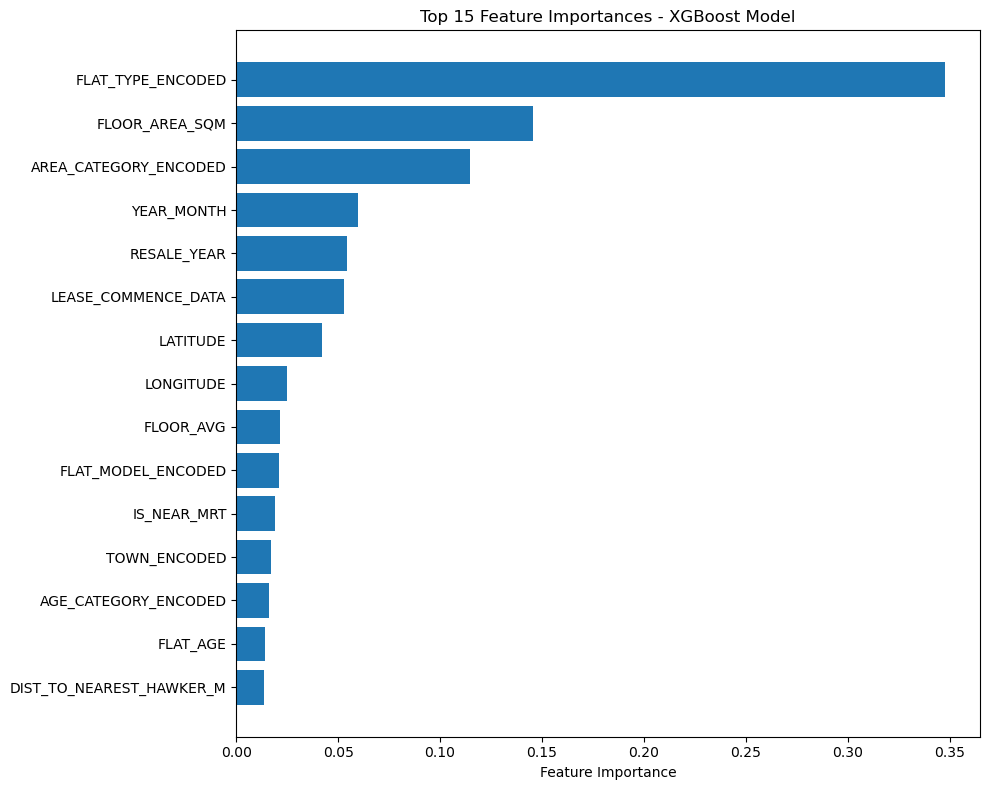

In [23]:
# Visualize top features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Prediction Distribution Visualization

In [24]:
# Use the predictions from the final model (already computed above)
predicted_price = test_predictions

print(f"\nPredictions generated for {len(predicted_price)} test samples.")
print(f"Price range: ${predicted_price.min():,.2f} - ${predicted_price.max():,.2f}")
print(f"Mean price: ${predicted_price.mean():,.2f}")
print(f"Median price: ${np.median(predicted_price):,.2f}")


Predictions generated for 50000 test samples.
Price range: $172,538.70 - $1,561,001.62
Mean price: $517,198.56
Median price: $486,166.12


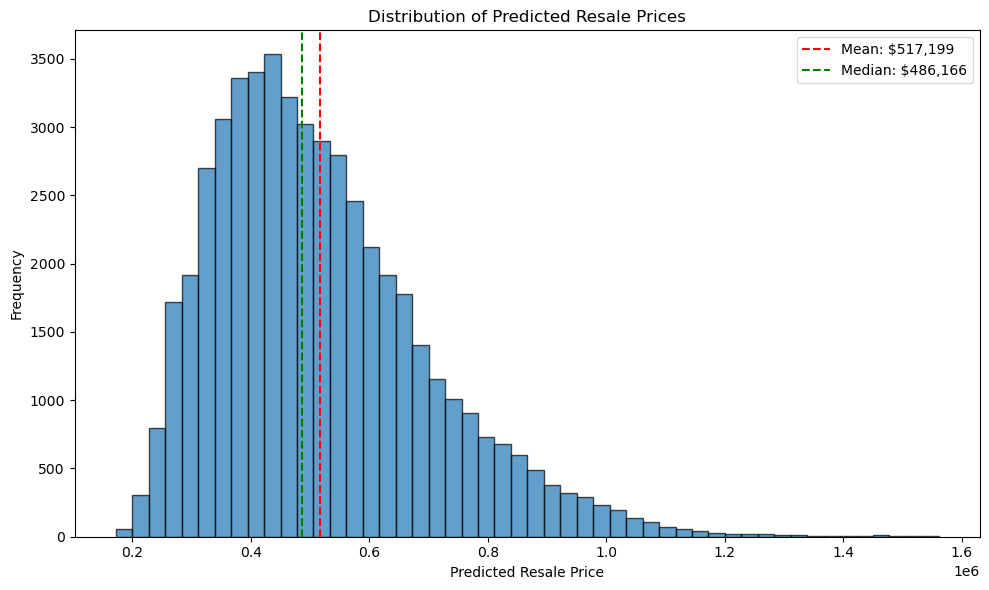

In [25]:
# Visualize prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(predicted_price, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Resale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Resale Prices')
plt.axvline(predicted_price.mean(), color='red', linestyle='--', label=f'Mean: ${predicted_price.mean():,.0f}')
plt.axvline(np.median(predicted_price), color='green', linestyle='--', label=f'Median: ${np.median(predicted_price):,.0f}')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Legacy Submission File (for comparison)

In [26]:
# Create legacy submission dataframe (for comparison with baseline methods)
legacy_submission_df = pd.DataFrame({
    'id': df_test.index,
    'Predicted': predicted_price
})

# Save to CSV
legacy_submission_df.to_csv(outpath + "submission_xgboost_legacy.csv", index=False)

print("\nLegacy submission file saved to:", outpath + "submission_xgboost_legacy.csv")
print("(Note: This uses 'id' column with original DataFrame index)")
print("\nFirst few predictions:")
print(legacy_submission_df.head(10))


Legacy submission file saved to: ../result/submission_xgboost_legacy.csv
(Note: This uses 'id' column with original DataFrame index)

First few predictions:
   id     Predicted
0   0  526722.50000
1   1  592418.25000
2   2  384113.09375
3   3  446831.87500
4   4  510030.09375
5   5  396143.15625
6   6  514228.09375
7   7  416183.25000
8   8  546313.81250
9   9  314921.71875


## 11. Model Performance Summary

In [27]:
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nModel: XGBoost Regressor with GridSearch Optimization")
print(f"Target Variable: Log-transformed Resale Price")
print(f"Cross-Validation: 5-Fold")
print(f"\nBest Hyperparameters:")
for param, value in best_params_optimized.items():
    print(f"  - {param}: {value}")
print(f"\nPerformance Metrics (on log-transformed price):")
print(f"  - RMSE: {best_rmse_cv:.4f}")
if 'mae_scores_best' in locals():
    print(f"  - MAE:  {mae_scores_best.mean():.4f}")
    print(f"  - R²:   {r2_scores_best.mean():.4f}")
else:
    print(f"  - MAE:  (will be calculated when model evaluation is run)")
    print(f"  - R²:   (will be calculated when model evaluation is run)")
print(f"\nTotal Features Used: {len(all_features)}")
print(f"  - Numerical: {len(numerical_features)}")
print(f"  - Categorical (Encoded): {len(encoded_categorical_features)}")
print("\n" + "="*60)


MODEL PERFORMANCE SUMMARY

Model: XGBoost Regressor with GridSearch Optimization
Target Variable: Log-transformed Resale Price
Cross-Validation: 5-Fold

Best Hyperparameters:
  - colsample_bytree: 0.8
  - gamma: 0
  - learning_rate: 0.05
  - max_depth: 7
  - min_child_weight: 5
  - n_estimators: 800
  - reg_alpha: 0
  - subsample: 0.8

Performance Metrics (on log-transformed price):
  - RMSE: 0.0487
  - MAE:  0.0364
  - R²:   0.9800

Total Features Used: 21
  - Numerical: 16
  - Categorical (Encoded): 5



## 12. Additional Analysis - Learning Curves

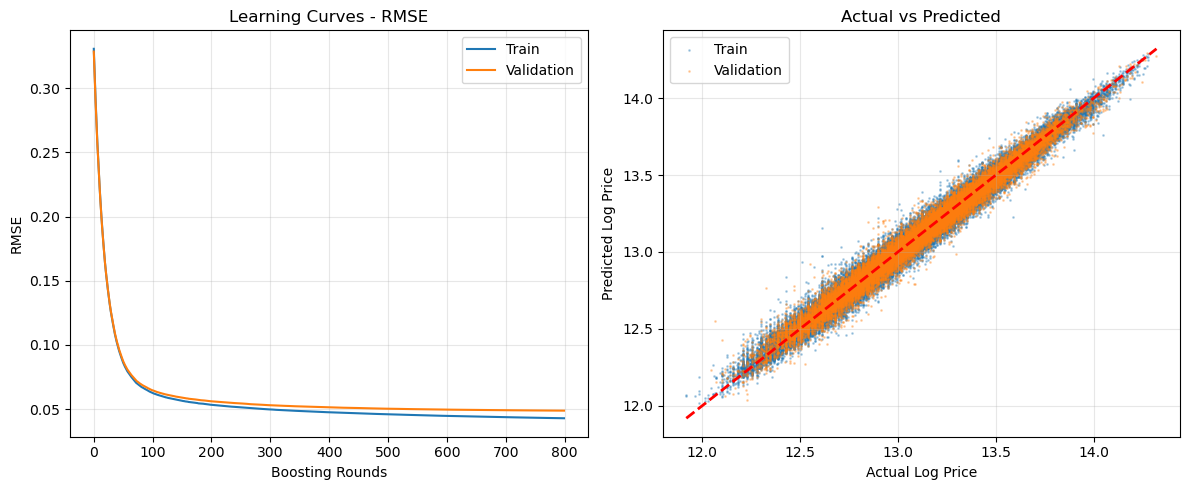


Validation RMSE: 0.0488
Validation MAE: 0.0364
Validation R²: 0.9797


In [28]:
# Split data for learning curve visualization
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train with early stopping to see performance
xgb_final = xgb.XGBRegressor(**best_params_optimized, random_state=42)

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_final.fit(X_train, y_train, 
              eval_set=eval_set,
              verbose=False)

# Get evaluation results
results = xgb_final.evals_result()

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curves - RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
train_pred = xgb_final.predict(X_train)
val_pred = xgb_final.predict(X_val)
plt.scatter(y_train, train_pred, alpha=0.3, label='Train', s=1)
plt.scatter(y_val, val_pred, alpha=0.3, label='Validation', s=1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nValidation RMSE: {np.sqrt(mean_squared_error(y_val, val_pred)):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, val_pred):.4f}")
print(f"Validation R²: {r2_score(y_val, val_pred):.4f}")